In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/My Drive

/content/drive/My Drive


In [3]:
import networkx as nx
import pandas as pd
import random
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score



In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
# Load the MovieLens ratings dataset
df = pd.read_csv('movielens_ratings.csv')

In [6]:
df

,Unnamed: 0,user_id,movie_id,rating,timestamp
0,0,1,1193,5,978300760
1,1,1,661,3,978302109
2,2,1,914,3,978301968
3,3,1,3408,4,978300275
4,4,1,2355,5,978824291
...,...,...,...,...,...
1000204,1000204,6040,1091,1,956716541
1000205,1000205,6040,1094,5,956704887
1000206,1000206,6040,562,5,956704746
1000207,1000207,6040,1096,4,956715648


In [7]:
# Filter the dataset to consider only high-interest ratings (4 or 5)
filtered_df = df[df['rating'].isin([4, 5])]

In [8]:

# Create an empty directed graph using NetworkX
graph = nx.DiGraph()

# Iterate over the high ratings DataFrame and add edges to the graph
for _, row in filtered_df.iterrows():
    user_id = row['user_id']
    movie_id = row['movie_id']
    graph.add_edge(user_id, movie_id)

# Print some basic information about the graph
print(f"Number of nodes: {graph.number_of_nodes()}")
print(f"Number of edges: {graph.number_of_edges()}")

Number of nodes: 6039
Number of edges: 575281


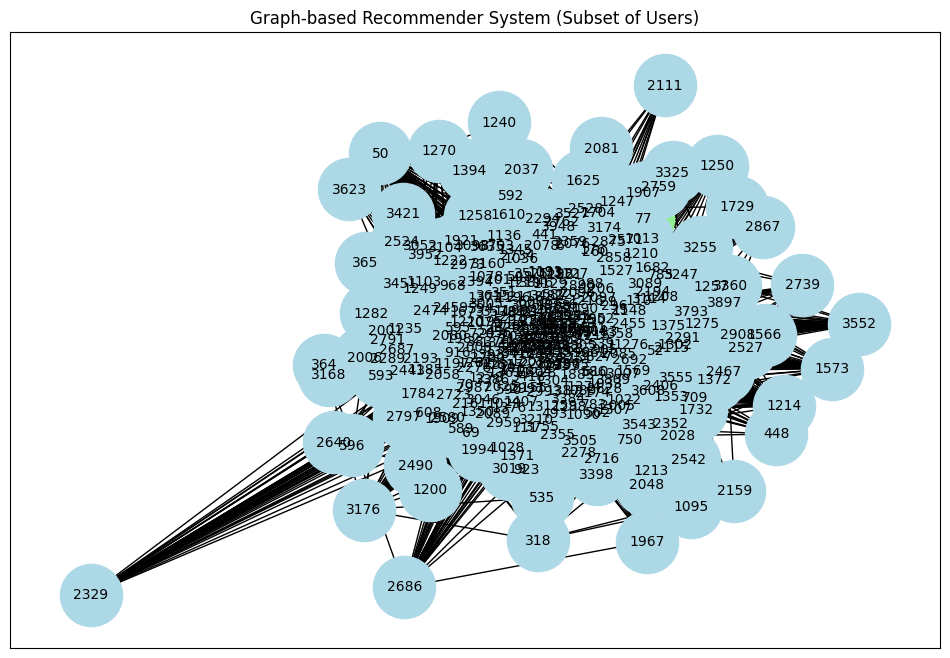

Chosen User IDs:
[6006, 536, 3180, 2993, 77]


In [9]:
# Select a random subset of users who rated highly
num_users_to_visualize = 5  # Adjust this value as desired
users_to_visualize = random.sample(filtered_df['user_id'].unique().tolist(), num_users_to_visualize)

# Create a subgraph containing only the selected users and their edges
subgraph = nx.subgraph(graph, users_to_visualize + filtered_df[filtered_df['user_id'].isin(users_to_visualize)]['movie_id'].tolist())

# Visualize the subgraph
pos = nx.spring_layout(subgraph, seed=42)  # Position nodes using a spring layout algorithm
plt.figure(figsize=(12, 8))  # Set the figure size

# Draw the user nodes with a different color
nx.draw_networkx_nodes(subgraph, pos, nodelist=users_to_visualize, node_color='lightgreen', node_size=2000)
# Draw the movie nodes
nx.draw_networkx_nodes(subgraph, pos, nodelist=[n for n in subgraph.nodes() if n not in users_to_visualize], node_color='lightblue', node_size=2000)

nx.draw_networkx_edges(subgraph, pos)  # Draw the edges

nx.draw_networkx_labels(subgraph, pos, font_size=10)  # Draw the labels

plt.title('Graph-based Recommender System (Subset of Users)')  # Set the title
plt.show()  # Show the plot

# Print the chosen user IDs
print("Chosen User IDs:")
print(users_to_visualize)

In [10]:
def calculate_precision_recall_F1(recset,testset):
  hit = list(set(recset).intersection(testset))
  if len(hit) < 1:
    return (0,0,0)
  precision = len(hit)/len(recset)
  recall = len(hit)/len(testset)
  F1 = (2*precision*recall) / (precision + recall)
  return(precision , recall , F1)

In [11]:
list_of_users = list(filtered_df['user_id'].unique())
users_to_recommend = random.sample(list_of_users, 10)

In [12]:
# Perform recommendations for each user
for user_id in users_to_recommend:
    recommendations_3 = []

    # Find paths of length 3 from the user
    paths_3 = nx.single_source_shortest_path(graph, user_id, cutoff=3)

    # Extract movie recommendations from the paths of length 3
    for target_user, path in paths_3.items():
        if len(path) == 4:  # Exclude paths longer than length 3
            movie_id = path[-1]
            recommendations_3.append(movie_id)

    # Remove already watched movies
    watched_movies = list(graph.neighbors(user_id))
    recommendations_3 = [movie_id for movie_id in recommendations_3 if movie_id not in watched_movies]
    # Print recommendations for the user
    print(f"User {user_id}:")
    print(f"Recommendations (Length 3): {recommendations_3[:10]}")
    print()

User 3897:
Recommendations (Length 3): [1272, 2402, 3062, 2280, 1646, 1302, 3896, 2194, 866, 3328]

User 243:
Recommendations (Length 3): [2288, 2660, 1200, 2944, 2968, 2987, 1250, 1253, 2202, 2067]

User 623:
Recommendations (Length 3): [3934, 1152, 1153, 3305, 3329, 1135, 1192, 844, 862, 121]

User 2984:
Recommendations (Length 3): [932, 955, 969, 1127, 2133, 2316, 2504, 3363, 2971, 2454]

User 5746:
Recommendations (Length 3): [3247, 2822, 2875, 468, 3831, 339, 60, 1202, 534, 3943]

User 2506:
Recommendations (Length 3): [2062, 3046, 3436, 1554, 1733, 123, 3528, 361, 378, 2801]

User 2397:
Recommendations (Length 3): [936, 1475, 1694, 2801, 299, 1131, 3831, 1150, 653, 2357]

User 5753:
Recommendations (Length 3): [3937, 3150, 1974, 3943, 767, 1614, 3078, 238, 3477, 3854]

User 4056:
Recommendations (Length 3): [3052, 1639, 457, 1517, 3328, 1732, 2700, 318, 180, 1962]

User 4572:
Recommendations (Length 3): [2060, 429, 2884, 2169, 2195, 325, 370, 2745, 1202, 996]



In [13]:
# Define relevant movies based on user ratings of 4 or 5 in the MovieLens ratings dataset
relevant_movies = set(filtered_df[filtered_df['rating'].isin([4, 5])]['movie_id'])

# Initialize variables to store true positives and recommended movies for each path length
true_positives_3 = 0
recommended_movies_3 = 0

# Perform recommendations for each user
for user_id in users_to_recommend:
    recommendations_3 = []
    # Find paths of length 3 from the user
    paths_3 = nx.single_source_shortest_path(graph, user_id, cutoff=3)

    # Extract movie recommendations from the paths of length 3
    for target_user, path in paths_3.items():
        if len(path) == 4:  # Exclude paths longer than length 3
            movie_id = path[-1]
            recommendations_3.append(movie_id)

    watched_movies = list(graph.neighbors(user_id))
    recommendations_3 = [movie_id for movie_id in recommendations_3 if movie_id not in watched_movies]
    # Update true positives and recommended movies for each path length
    true_positives_3 += len(set(recommendations_3) & relevant_movies)
    recommended_movies_3 += len(recommendations_3)

# Calculate precision, recall, and F1-score for each path length
num_total_relevant_movies = len(filtered_df[filtered_df['rating'].isin([4, 5])])
recall_3 = true_positives_3 / num_total_relevant_movies
precision_3 = true_positives_3 / recommended_movies_3
f1_score_3 = 2 * (precision_3 * recall_3) / (precision_3 + recall_3)

# Print the results for each path length
print("Results (Path Length 3):")
print("Precision:", precision_3)
print("Recall:", recall_3)
print("F1-score:", f1_score_3)
print()



Results (Path Length 3):
Precision: 1.0
Recall: 0.032081713110636366
F1-score: 0.062168940119952096



In [14]:
def path_five_recommendations(graph, train_items):
    items = pd.Series(dtype='float64')
    counter = 0
    stack = []

    for item1 in train_items:
        stack.append((item1, graph.predecessors(item1), 1))

    while stack and counter < 100000:
        item, predecessors, depth = stack.pop()

        if depth >= 5:
            items.loc[item] = items.get(item, 0) + 1
            counter += 1
        else:
            for user in predecessors:
                for neighbor_item in graph.neighbors(user):
                    stack.append((neighbor_item, graph.predecessors(neighbor_item), depth + 1))

    return items.sort_values(ascending=False).drop(train_items, errors='ignore').head(10)

def path_seven_recommendations(graph, train_items):
    items = pd.Series(dtype='float64')
    counter = 0
    stack = []

    for item1 in train_items:
        stack.append((item1, graph.predecessors(item1), 1))

    while stack and counter < 100000:
        item, predecessors, depth = stack.pop()

        if depth >= 7:
            items.loc[item] = items.get(item, 0) + 1
            counter += 1
        else:
            for user in predecessors:
                for neighbor_item in graph.neighbors(user):
                    stack.append((neighbor_item, graph.predecessors(neighbor_item), depth + 1))

    return items.sort_values(ascending=False).drop(train_items, errors='ignore').head(10)

In [15]:
for user in users_to_recommend:
    print(f"Recommendations for user {user} (5-path):")
    recommended_items_5 = path_five_recommendations(graph , [user])
    recommended_items_5 = list(set(recommended_items_5))
    print(f"Recommendations of path 5 for user {user}:")
    print(' '.join(str(item) for item in recommended_items_5))
    print()

Recommendations for user 3897 (5-path):
Recommendations of path 5 for user 3897:
324 360 415 301 305 339 628 311 412 351

Recommendations for user 243 (5-path):
Recommendations of path 5 for user 243:


Recommendations for user 623 (5-path):
Recommendations of path 5 for user 623:
448 292 305 277 280 347 285 350 287

Recommendations for user 2984 (5-path):
Recommendations of path 5 for user 2984:
323 291 294 295 296 299 304 369 310

Recommendations for user 5746 (5-path):
Recommendations of path 5 for user 5746:


Recommendations for user 2506 (5-path):
Recommendations of path 5 for user 2506:
324 360 415 301 305 339 628 311 412 351

Recommendations for user 2397 (5-path):
Recommendations of path 5 for user 2397:
291 326 296 266 268 270 271 275 412

Recommendations for user 5753 (5-path):
Recommendations of path 5 for user 5753:


Recommendations for user 4056 (5-path):
Recommendations of path 5 for user 4056:


Recommendations for user 4572 (5-path):
Recommendations of path 5 for user

In [ ]:
precision_list = []
recall_list = []
f1_list = []
for user in users_to_recommend:
  user_items = graph.neighbors(user)
  user_items_list = [int(i) for i in user_items]
  train_items , test_items = train_test_split(user_items_list, test_size=0.3, random_state=42)
  five_path_recommended_items = path_five_recommendations(graph, train_items)
  precision , recall , f1 = calculate_precision_recall_F1(five_path_recommended_items.index ,test_items)
  precision_list.append(precision)
  recall_list.append(recall)
  f1_list.append(f1)
print(f"precision = {np.mean(precision_list)} , recall = {np.mean(recall_list)} , f1 = {np.mean(f1_list)}")


precision = 0.13 , recall = 0.050891861761426974 , f1 = 0.06284489518488677


In [16]:
for user in users_to_recommend:
    print(f"Recommendations for user {user} (7-path):")
    recommended_items_7 = path_seven_recommendations(graph, [user])
    recommended_items_7 = list(set(recommended_items_7))
    print(f"Recommendations of path 7 for user {user}:")
    print(' '.join(str(item) for item in recommended_items_7))
    print()

Recommendations for user 3897 (7-path):
Recommendations of path 7 for user 3897:
324 360 415 301 305 339 628 311 412 351

Recommendations for user 243 (7-path):
Recommendations of path 7 for user 243:


Recommendations for user 623 (7-path):
Recommendations of path 7 for user 623:
448 292 305 277 280 347 285 350 287

Recommendations for user 2984 (7-path):
Recommendations of path 7 for user 2984:
323 291 294 295 296 299 304 369 310

Recommendations for user 5746 (7-path):
Recommendations of path 7 for user 5746:


Recommendations for user 2506 (7-path):
Recommendations of path 7 for user 2506:
324 360 415 301 305 339 628 311 412 351

Recommendations for user 2397 (7-path):
Recommendations of path 7 for user 2397:
291 326 296 266 268 270 271 275 412

Recommendations for user 5753 (7-path):
Recommendations of path 7 for user 5753:


Recommendations for user 4056 (7-path):
Recommendations of path 7 for user 4056:


Recommendations for user 4572 (7-path):
Recommendations of path 7 for user

In [ ]:
precision_list = []
recall_list = []
f1_list = []
for user in users_to_recommend:
  user_items = graph.neighbors(user)
  user_items_list = [int(i) for i in user_items]
  train_items , test_items = train_test_split(user_items_list, test_size=0.3, random_state=42)
  seven_path_recommended_items = path_seven_recommendations(graph, train_items)
  precision , recall , f1 = calculate_precision_recall_F1(seven_path_recommended_items.index ,test_items)
  precision_list.append(precision)
  recall_list.append(recall)
  f1_list.append(f1)
print(f"precision = {np.mean(precision_list)} , recall = {np.mean(recall_list)} , f1 = {np.mean(f1_list)}")

precision = 0.12 , recall = 0.05875825928457508 , f1 = 0.06769561470153337
